In [1]:
%load_ext autoreload
%autoreload 2

import time
from functools import partial

import network
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool

from numba import jit, objmode, types
from numba import int32, uint32, float32, bool

Echter code befindet sich in ex2b.py. Jupyter verträgt sich nicht mit multiprocessing. Daher nur plotten der Ergebnissse hier.

In [44]:
@jit()
def to_str(num):
    return f'{int(num * 1e6)}'

@jit(float32(int32, float32, float32[:])) # annotate to tell numba to compile (argument is the method signature, its optional but can help prevent issues)
def calc_pc_once2(L, min_p=0.5, info=None):
    if info is None: info = np.zeros(2, dtype=np.float32)
    step_step = 5.0 # factor to decrease step by
    step = 0.02 * step_step # amount to increase p by each iteration (increased, because it's decreased at the start)
    p = min_p + step # start p ((increased, because it's decreased at the start))
    for i in range(5): # divide step 5 times in total
        p -= step # go back a step because it might have percolated
        step /= step_step # lower resolution and search again, start with 0.02 -> 0.004 -> 0.0008 -> 0.00016 -> 0.000032 -> 0.0000064
        percolated = False
        while not percolated:
            n = network.Network(int(L), int(L), p)
            n.hoshen_kopelman()
            info[1] += 1 # total number of grids
            if n.is_percolating():
                if i == 0 and p < min_p + step:
                    raise Exception("starting p was set to high")
                percolated = True # search again with lower resolution
            else:
                p += step # not percolating, try higher p
    return p

# finds smallest p where a grid of size L perculates with multiple runs and averaging the result
@jit(float32(int32, float32, int32, float32[:]), fastmath=True)
def calc_pc(L, min_p=0.50, amount=50, fail=None):
    pcs = np.zeros(amount)
    for i in range(amount):
        pcs[i] = calc_pc_once2(L, min_p, fail)
    #print(pcs)
    return np.average(pcs[pcs > 0])

def do_ex(L, min_p=0.50, amount=50):
    info = np.zeros(2, dtype=np.float32)
    t = time.perf_counter()
    pc = calc_pc(L, min_p, amount, info)
    print(f'Size {L} took {round(time.perf_counter() - t, 4)} seconds for a total of {info[1]} grids and min_p {min_p}')
    return pc

In [45]:

exp = np.array(range(3, 11 + 1))
pc = np.zeros(len(exp))
for i in exp:
    pc[i-3] = do_ex(2**i, min_p=0.5 if i >= 6 else (i-1)*0.1)


Size 8 took 0.0072 seconds for a total of 2000.0 grids and min_p 0.2
Size 16 took 0.0089 seconds for a total of 1448.0 grids and min_p 0.30000000000000004
Size 32 took 0.0209 seconds for a total of 1343.0 grids and min_p 0.4
Size 64 took 0.0525 seconds for a total of 1007.0 grids and min_p 0.5
Size 128 took 0.1975 seconds for a total of 1055.0 grids and min_p 0.5
Size 256 took 0.6773 seconds for a total of 943.0 grids and min_p 0.5
Size 512 took 4.2073 seconds for a total of 1029.0 grids and min_p 0.5
Size 1024 took 20.0864 seconds for a total of 1054.0 grids and min_p 0.5
Size 2048 took 83.0835 seconds for a total of 1068.0 grids and min_p 0.5


In [47]:
old_exp = exp
old_pc = pc

def reset():
    exp = old_exp
    pc = old_pc

def do_next():
    global exp, pc
    exp = np.array([*exp, exp[-1] + 1])
    pc = np.array([*pc, 0])
    pc[-1] = do_ex(2**exp[-1], min_p=0.5)

In [48]:
do_next() # 4096

Size 4096 took 336.4027 seconds for a total of 1074.0 grids and min_p 0.5


In [50]:
do_next() # 8192

Size 8192 took 1241.4763 seconds for a total of 1033.0 grids and min_p 0.5


In [ ]:
do_next()

[0.50899071 0.55429119 0.57380414 0.58353597 0.58836418 0.59035325
 0.59151167 0.59216255 0.59221762 0.59254915 0.592592  ]


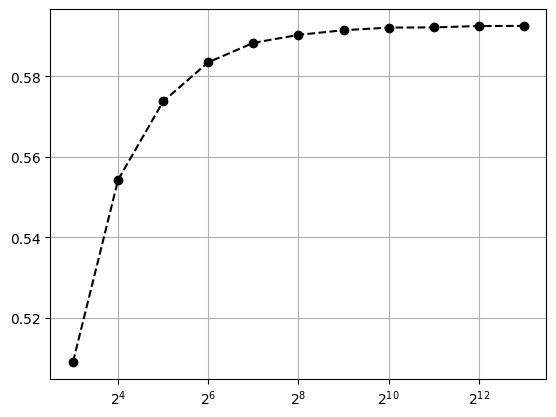

In [51]:
print(pc)
fig, ax = plt.subplots()
ax.plot(2**exp, pc, 'ok--')
ax.set_xscale('log', base=2)
plt.grid(True)

Bei Berechnung in eins ist wenig Kontrolle über einzelne $L$. Einzeln berechnen und Ergebnis in Array eintragen ist vorteilhafter.

Bei 20 Prozessen kommt es ab $L=2^{13}$ zu Arbeitsspeicher Problemen. Durch Verringerung auf 10 Prozesse konnte $p_c$ in etwa 30 Min. berechnet werden.
$L=2^{14}$ könnte Schätzungsweise in 1 bis 2 h berechnet werden, Auflösung müsste aber kleiner gewählt werden für aussagekräftiges Ergebnis.
 
Ergebniss: $\lim_{L\rightarrow\infty} p_c \approx 60\%$